# Import Packages

In [21]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



# Import Cleaned Data

In [22]:
data_clean = pd.read_csv('data_clean.csv')
data_clean.sample(frac=1)
Characters_per_rank = (data_clean.Characters.value_counts()).index 
data_clean = data_clean[:30000]
data_clean.shape

(30000, 6)

In [23]:
#truncate dataset based on number of characters we want to verify
threshold = 6
data_thres = data_clean[data_clean.Characters.isin(Characters_per_rank[:threshold])]

# split the clean text in the rows  into list of words
tokenized_data = data_thres["Lines"].apply(lambda text: re.split(' ',text))

# Label Character
label = preprocessing.LabelEncoder()
target = label.fit_transform(data_clean['Characters'].astype(str))
data_thres['target'] = label.fit_transform(data_thres['Characters'].astype(str))
target_thres = data_thres['target'] 
my_tags = Characters_per_rank[0:threshold]

data_thres.head()


C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,2
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,0
3,3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,3
4,4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,3


## Convert Lines into TFIDF Features

In [24]:
# Create a BoW with TF-IDF Scheme 
def tfidf(data):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))

    tfidf_result = tfidf.fit_transform(data).toarray()
    tfidf_features = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
    tfidf_features.index = data.index
    return tfidf_features


tfidf_df = tfidf(data_thres['Lines'])


In [25]:
#Macro roc_auc score after feature engineering
model =  LogisticRegression(C=1,max_iter = 1e3,penalty='l2')
x_train, x_test, y_train, y_test = train_test_split(tfidf_df,target_thres, test_size = 0.2,random_state =42)

model.fit(x_train, y_train)
y_prob = model.predict_proba(x_test)
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
print("Macro_ROC_AUC Score:",macro_roc_auc_ovo)
score = model.score(x_test,y_test)
print("Accuracy:", score)

Macro_ROC_AUC Score: 0.6454205333402595
Accuracy: 0.28717651602935496


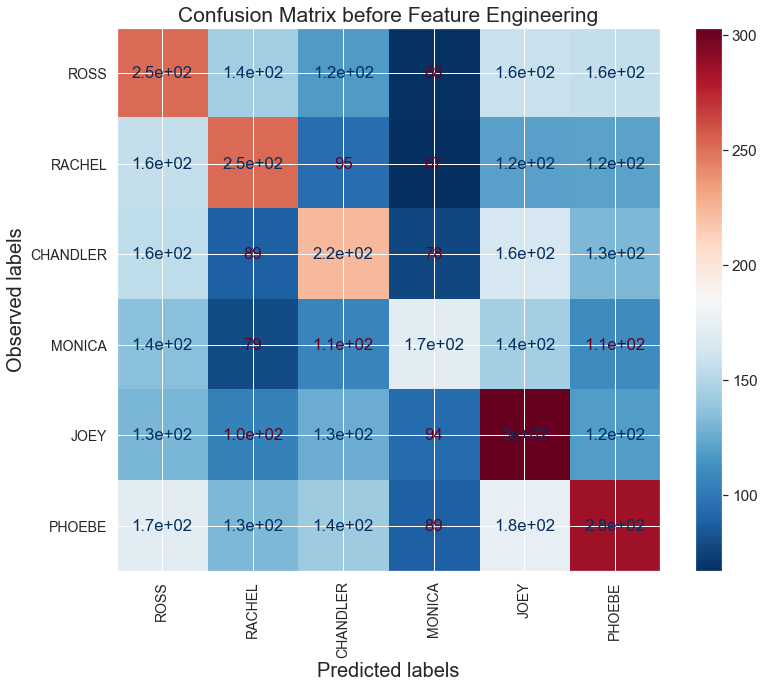

In [26]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
fig = plt.figure(figsize=(1.25*10,10))
ax = plt.axes()
ax.set_title('Confusion Matrix')

class_names =data_thres['Characters'].value_counts().index
sns.set(font_scale=1.4) # Adjust to fit
plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap="RdBu_r",ax=ax, xticks_rotation='vertical')


# Labels, title and ticks
label_font = {'size':'20'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix before Feature Engineering', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust to fit


plt.show()

# Improving Accuracy
## Feature Engineering: Assign Extra Input Features

In [27]:
Gender={1: ['RACHEL','MONICA','PHOEBE'],2:['ROSS','CHANDLER','JOEY']}
assign_group={}
for key,values in Gender.items():
    for val in values:
        assign_group[val]=key
data_thres['Gender']=data_thres.Characters.apply(lambda x: assign_group[x])
# Filter lines with str length<50
mask=[True if len(x)>25 else False for x in data_thres.Lines]
data_thres = data_thres[mask]

tfidf_df = tfidf(data_thres['Lines'])
data_thres.head()

C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target,Gender
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,2,1
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1,2
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,0,2
5,5,101,Monica Gets A Roommate,MONICA,okay everybody relax even date two people go d...,1,2,1
7,7,101,Monica Gets A Roommate,CHANDLER,alright i'm back high school i'm stand middle ...,1,0,2


In [29]:
#Result with Feature Engineering
X= pd.concat([tfidf_df,data_thres.Gender],axis = 1)
target_thres = data_thres['target'] 
Eval_score =  cross_val_score(model,X, target_thres, cv=5)
print(Eval_score)


[0.45884206 0.46278062 0.46750689 0.4822695  0.44168637]


In [30]:
#Macro roc_auc score after feature engineering
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

model =  LogisticRegression(C=1,max_iter = 1e3,penalty='l2')
x_train, x_test, y_train, y_test = train_test_split(X,target_thres, test_size = 0.2,random_state =42)

model.fit(x_train, y_train)
y_prob = model.predict_proba(x_test)
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
print("Macro_ROC_AUC Score:",macro_roc_auc_ovo)
score = model.score(x_test,y_test)
print("Accuracy:", score)

Macro_ROC_AUC Score: 0.8723369656434067
Accuracy: 0.49192595510043324


## GridSearch Parameters for Logistic Regression

In [ ]:
## Grid Search
##takes long time to run, so commented after running once

# from sklearn.model_selection import GridSearchCV
# model =  LogisticRegression()
# params_log = { "C": [1e-2,1, 10, 1e2,1e6], "max_iter":[100,1e3,1e6]}

# grid_log = GridSearchCV(model, param_grid=params_log, cv=5)
# grid_log.fit(X,target_thres)

# print(grid_log.best_score_) #best score was 0.8483
# print(grid_log.best_params_)# paramters were {'C': 1, 'max_iter': 100.0}

## Oversampling

In [12]:

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

model =  LogisticRegression(C=1,max_iter = 1e3,penalty='l2')
x_train, x_test, y_train, y_test = train_test_split(X,target_thres, test_size = 0.2,random_state =42)

ros_ov = RandomOverSampler(random_state=0)
x_train_resampled, y_train_resampled = ros_ov.fit_sample(x_train, y_train)

model.fit(x_train_resampled, y_train_resampled)
y_prob = model.predict_proba(x_test)
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
print("Macro_ROC_AUC Score:",macro_roc_auc_ovo)
score = model.score(x_test,y_test)
print("Accuracy:", score)

C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Macro_ROC_AUC Score: 0.8572174713773603
Accuracy: 0.462726921591348


## Confusion Matrx after Feature Engineering and Resampling 

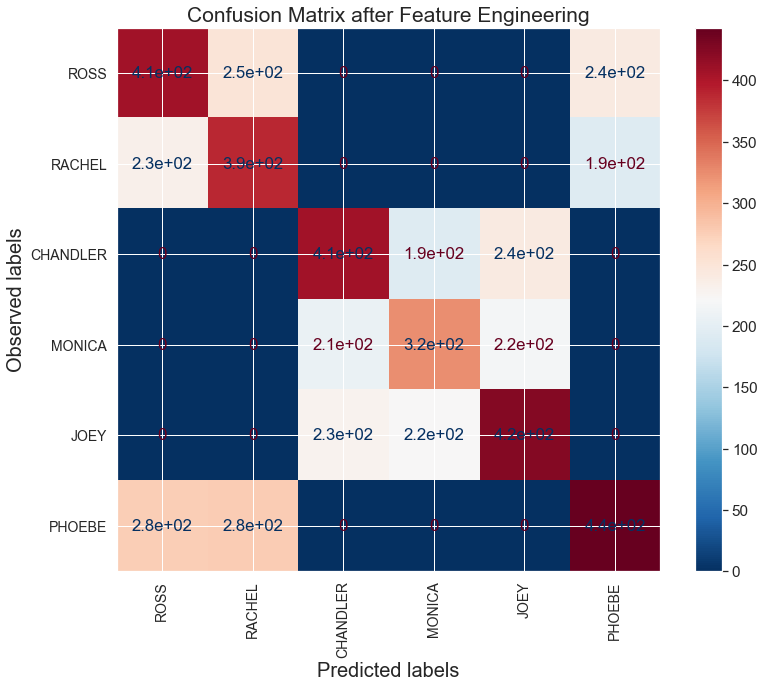

In [13]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
fig = plt.figure(figsize=(1.25*10,10))
ax = plt.axes()
ax.set_title('Confusion Matrix')

class_names =data_thres['Characters'].value_counts().index
sns.set(font_scale=1.4) # Adjust to fit
plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap="RdBu_r",ax=ax, xticks_rotation='vertical')

# Labels, title and ticks
label_font = {'size':'20'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix after Feature Engineering', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust to fit


plt.show()

In [ ]:
macro_roc_auc_ovo